In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IPositionGathering, IStrategy, PositionsTracker, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.utils.charting.lookinglass import LookingGlass
from qubx.core.utils import recognize_time, time_to_str

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals
from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer, FixedLeverageSizer

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
signals = pd.read_csv("../tests/data/generated_signals.csv", index_col="timestamp", parse_dates=True)
print(signals.index[0], signals.index[-1])

exchange = "BINANCE.UM"
symbol = "BTCUSDT"
# reader = CsvStorageDataReader("../tests/data/csv")
# ohlc = reader.read("BTCUSDT_ohlcv_M1", start='2023-08-13', stop='2024-04-30', transform=AsOhlcvSeries())
qdb = MultiQdbConnector('xlydian-data')
ohlc = qdb.read(f"{ exchange }:{symbol}", start=signals.index[0], stop='2024-05-01', transform=AsPandasFrame())

2023-08-13 17:23:33.720000 2024-04-30 22:30:00.030000


2024-09-06 17:47:14.076 [ 🐞 ] Connected to QuestDB at xlydian-data:8812


In [3]:
reader = CsvStorageDataReader("../tests/data/csv")
ohlc = reader.read("BTCUSDT_ohlcv_M1",  transform=AsPandasFrame())

S = pd.DataFrame({'BTCUSDT': {
    pd.Timestamp('2024-01-10 15:08:59.716000'): 1,
    pd.Timestamp('2024-01-10 15:10:52.679000'): 1,
    pd.Timestamp('2024-01-10 15:32:44.798000'): 1,
    pd.Timestamp('2024-01-10 15:59:55.303000'): 1,
    pd.Timestamp('2024-01-10 16:09:00.970000'): 1,
    pd.Timestamp('2024-01-10 16:12:34.233000'): 1,
    pd.Timestamp('2024-01-10 19:16:00.905000'): 1,
    pd.Timestamp('2024-01-10 19:44:37.785000'): 1,
    pd.Timestamp('2024-01-10 20:06:00.322000'): 1}})

In [4]:
# S = signals['2023-08-27 14:00':'2023-08-29 14:30']
# S = signals
# S = signals['2024-02-26 00:00':'2024-02-27 00:00']
rep = simulate(
    { 
        "liq_buy_bounces_c": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")],
        "liq_buy_bounces_b": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")],
     },
    {f"{exchange}:{symbol}" : ohlc}, 
    10000, [exchange + ":" + symbol], dict(type="ohlc", timeframe="1Min"), "1Min -1Sec", "vip9_usdt", 
    S.index[0], S.index[-1] + pd.Timedelta('5Min'), 
    debug='DEBUG')

  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-06 17:48:45.231 [ 🐞 ] 2024-01-10 15:08:59.716000 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-10 15:08:59.716 [ℹ️] SimulatedData.binance.um initialized
2024-01-10 15:08:59.716 [🐞] Using pre-generated signals:
 BTCUSDT    9



Simulating:   0%|          | 0/17820.606 [00:00<?, ?s/s]

2024-01-10 15:08:59.716 [🐞] Triggering strategy on every 1Min bar after 
2024-01-10 15:08:59.716 [🐞] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 1} for 
	['BTCUSDT'] 
2024-01-10 15:08:59.716 [🐞] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-10 15:08:59.716 [ℹ️] SimulatedExchangeService :: run :: Simulation started at 2024-01-10 15:08:59.716000
2024-01-10 15:08:59.716 [🐞] Initializing chunks for each loader
2024-01-10 15:08:59.716 [🐞] Initializing chunks for each loader
2024-01-10 15:09:00.001 [🐞] Invoking SignalsProxy on_fit('2024-01-10 15:08:59.716000', 'None')
2024-01-10 15:09:00.001 [🐞] SignalsProxy is fitted
2024-01-10 15:09:00.001 [🐞] ClientSideRiskController new signal received: Target for SignalsProxy 45161.90 +1.000000 BTCUSDT stop: 44936.140250000004 take: 46290.99875 on BINANCE.UM [] -> 0.022 at 2024-01-10T15:09:00.001000000 for BTCUSDT take: 46290.99875 stop: 44936.140250000004
2024-01-10 15:09:00.001 [🐞] (StrategyCon

Simulating:   0%|          | 0/17820.606 [00:00<?, ?s/s]

2024-01-10 15:08:59.716 [🐞] Initializing chunks for each loader
2024-01-10 15:08:59.716 [🐞] Initializing chunks for each loader
2024-01-10 15:09:00.001 [🐞] Invoking SignalsProxy on_fit('2024-01-10 15:08:59.716000', 'None')
2024-01-10 15:09:00.001 [🐞] SignalsProxy is fitted
2024-01-10 15:09:00.001 [🐞] BrokerSideRiskController new signal received: Target for SignalsProxy 45161.90 +1.000000 BTCUSDT stop: 44936.140250000004 take: 46290.99875 on BINANCE.UM [] -> 0.022 at 2024-01-10T15:09:00.001000000 for BTCUSDT take: 46290.99875 stop: 44936.140250000004
2024-01-10 15:09:00.001 [🐞] (StrategyContext) sending market buy for 0.022 of BTCUSDT @ None ...
2024-01-10 15:09:00.001 [🐞] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.022 executed at 45161.950000000004
2024-01-10 15:09:00.001 [🐞]   ::  traded 0.022 for BTCUSDT @ 45161.950000000004 -> 0.00
2024-01-10 15:09:00.001 [🐞] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.022 of BTCUSDT -> CLOSED
2024-01-10 15:09:00.001 [🐞] [SIM-ORDER-BTCUSD

2024-01-10 20:06:59.999 [ℹ️] SimulatedExchangeService :: run :: Simulation finished at 2024-01-10 20:06:00.322000


In [5]:
rep[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-10 15:09:00.001,BTCUSDT,buy,0.022,45161.95,0.168906,USDT
2024-01-10 17:44:36.000,BTCUSDT,sell,-0.022,46327.55,0.173265,USDT
2024-01-10 19:16:24.000,BTCUSDT,buy,0.021,46320.85,0.165365,USDT
2024-01-10 19:39:24.000,BTCUSDT,sell,-0.021,46075.55,0.164490,USDT
2024-01-10 19:44:59.999,BTCUSDT,buy,0.021,46264.85,0.165166,USDT


In [6]:
rep[1].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-10 15:09:00.001,BTCUSDT,buy,0.022,45161.95,0.168906,USDT
2024-01-10 17:44:36.000,BTCUSDT,sell,-0.022,46291.00,0.000000,USDT
2024-01-10 19:16:24.000,BTCUSDT,buy,0.021,46320.85,0.165365,USDT
2024-01-10 19:39:24.000,BTCUSDT,sell,-0.021,46089.30,0.164539,USDT
2024-01-10 19:44:59.999,BTCUSDT,buy,0.021,46264.85,0.165166,USDT


In [9]:
from qubx.core.metrics import portfolio_metrics


# rep

mtrx = portfolio_metrics(
    rep[1].portfolio_log,
    rep[1].executions_log,
    rep[1].capital,
    account_transactions=False,
    commission_factor=1,
)
mtrx['gain']

c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


23.363900000000285

c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\dmitr\devs\Qubx\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,/liq_buy_bounces_c,23.042059,1.316524,0.0,2.654414,0.069273,6.945705,0.0,0.0,1.0,0.0,0.0,0.230421,0.837191,5.0
1,/liq_buy_bounces_b,22.699925,1.287840,0.0,2.695197,0.066398,6.657004,0.0,0.0,1.0,0.0,0.0,0.226999,0.663975,5.0


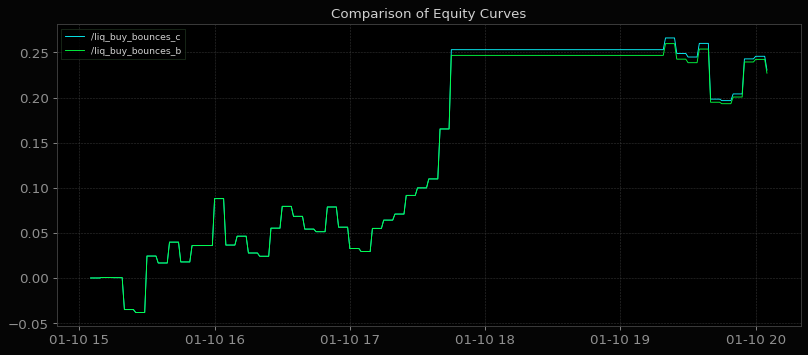

In [10]:
tearsheet(rep)

In [187]:
chart_signals(rep[1], symbol, ohlc, '1Min',  show_signals=True)